![A Cloud Guru](acg_logo.png)
<hr/>

<center><h1>MXNet Image Classification</h1></center>

![Sorting Lego bricks](./lego.jpg)

<center><h2>Lego Brick Sorting</h2></center>

# Frameworks
For this lab, we will be using Apache MXNet to build and train a model to classify images, and specifically take advantage of the Gluon API provided with MXNet to make that process really easy.

## MXNet

A flexible and efficient library for deep learning.

- MXNet provides optimized numerical computation for GPUs and distributed ecosystems, from the comfort of high-level environments like Python and R.
- MXNet automates common workflows, so standard neural networks can be expressed concisely in just a few lines of code.

_(Source: https://mxnet.apache.org/)_

## Gluon

Based on the the Gluon API specification, the Gluon library in Apache MXNet provides a clear, concise, and simple API for deep learning. It provides basic building blocks for neural networks that make it easy to prototype, build, and train deep learning models without sacrificing training speed. Install a recent version of MXNet to get access to Gluon.

_(Source: [AWS Blog](https://aws.amazon.com/blogs/machine-learning/introducing-gluon-an-easy-to-use-programming-interface-for-flexible-deep-learning/))_


# Scenario

We have bricks. Lots of bricks. LEGO bricks, that is. And we need to sort them.

We also have a collection of photos of various LEGO bricks from different angles. We have 600 photos (which probably took us more time to collect than sorting the current bricks) and they are all labeled with the brick type.

Each photo has been processed. This involved increasing the contrast, sharpening, removing the color, inverting the colors, and reducing the size.

|![Sample LEGO brick photo](./sample-before.png)|![Sample LEGO brick photo](./sample-after.png)|
|----------------------------------------|----------------------------------------|
| Sample before processing                | Sample after processing                |

In addition to this, we stored all the images into data arrays for easier loading into the notebook. These are stored in the `lego-simple-mx-train` and `lego-simple-mx-test` files.

We need to create a simple, deep learning, neural network classifier model. We will train the model using the photo data and see if it correctly predicts the type of a brick from a supplied test image.

# How to Use This Lab

All of the code is provided for you in this lab as our solution to the tasks presented. You could simply execute the notebook to get a result, but that's not really very hands-on and it won't teach you anything but how to execute cells in a Jupyter notebook. To get the most from this lab, you should understand what the code in each cell is trying to accomplish, and then take the time to experiment: make changes, break it, fix it, and learn! You can always pull the code down again to get a clean copy.

# 1) Preparing our Environment

First, we'll need to install the `mxnet` package to run everything. Since it's not included in the `conda_python` image by default, we'll need to use `pip` to install it.

In [1]:
%pip install mxnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 10.0 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


Now that MXNet has been installed, we can import all of the modules we'll need to build and run our image classification model.

In [2]:
import mxnet as mx
from mxnet.gluon.data.vision import transforms

from mxnet import nd, gluon, autograd
from mxnet.gluon import nn

import pickle

import numpy as np
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


Since this is part of a learning environment, we'll also include a fixed seed. This means your results should follow what you experience in the hands-on lab, although you can also change this, or comment it out entirely for different results.

And of course, there's only one seed that which would be appropriate to help us figure out life, the universe, and everything

In [3]:
mx.random.seed(42)

Lastly, we need to set the processor type MXNet will use. This Juypter Notebook server doesn't have access to GPU's and we let MXNet discover that here. That will be okay for what we are doing.

In [4]:
ctx = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu(0)

In [5]:
ctx

cpu(0)

# 2) Load the Data

We have a dataset created from a set of photos of LEGO bricks. In total we have 2 sets of data saved to files as NDArrays.

1. __lego-simple-mx-train__ - _Training images and labels combined, around 80% of the data collected._
2. __lego-simple-mx-test__ - _Testing or validation images and labels combined, around 20% of the data collected._

First we load the data into runtime arrays. ```Pickle``` has been used to create these object files, so we use ```pickle``` to load them as well.

In [6]:
# TODO: Load the training and testing data into the `train_data` and `test_data` variables
train_fh = open('lego-simple-mx-train', 'rb')
test_fh = open('lego-simple-mx-test', 'rb')

train_data = pickle.load(train_fh)
test_data = pickle.load(test_fh)

The label data we loaded are integer values (1,2,3). We want human names for the data classes we're working with.

In [7]:
# For humans:
class_names = ['2x3 Brick', '2x2 Brick', '1x3 Brick', '2x1 Brick', '1x1 Brick', 
               '2x2 Macaroni', '2x2 Curved End', 'Cog 16 Tooth', '1x2 Handles', '1x2 Grill']

# Or the real LEGO codes:
# class_names = ['3002', '3003', '3622', '3004', '3005', '3063', '47457', '94925', '3839a', '2412b']

## Convert to MXNet Tensors

We have the data loaded into NDArrays. Now we transfer the data into MXNet tensors.

Tensors act like arrays but with extra capability. 

In [8]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.13, 0.31)])

train_data = train_data.transform_first(transformer)
test_data = test_data.transform_first(transformer)

Let's take a look at one of the images loaded with the data.

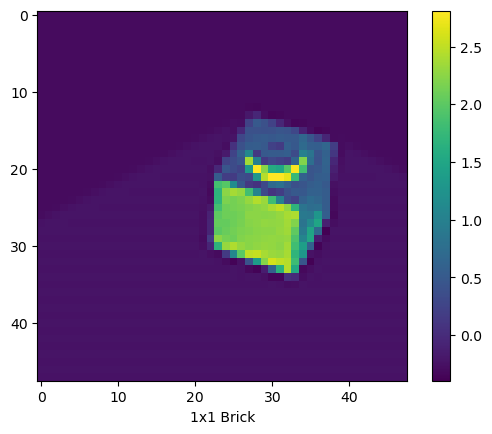

In [9]:
train_image_no = 0

images_data, label_data = train_data[train_image_no]
plt.figure()
plt.imshow(images_data.reshape((48,48)).asnumpy())
plt.colorbar()
plt.xlabel(class_names[label_data])
plt.show()

Let's look at some more of the data and make the formating a little nicer.

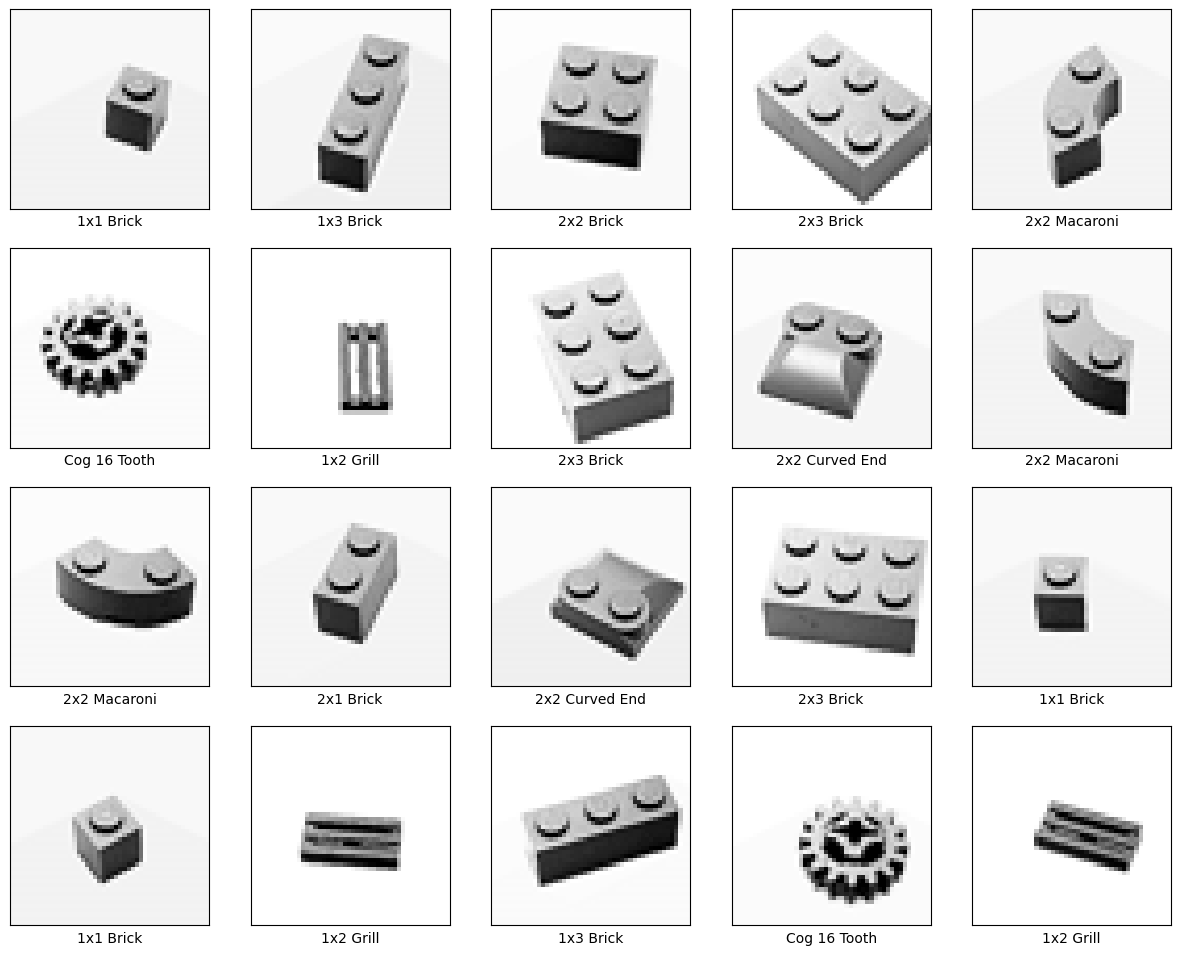

In [10]:
plt.figure(figsize=(15,15))
for i in range(20):
    images_data, label_data = train_data[i]
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(images_data.reshape((48,48)).asnumpy(), cmap=plt.cm.binary)
    plt.xlabel(class_names[label_data])
plt.show()

# 3) Create the Model

Now the data is loaded, so let's start training. First, we need to create a model. With MXNet we often call the model object ```net```. We are creating an artificial neural network. It has 4 layers:

1. The input layer with enough nodes for our image data.
2. A hidden layer with 128 nodes and ReLU activation.
3. A hidden layer with 64 nodes and ReLU activation.
4. An output layer with 10 nodes, one for each of the classes we want to identify.

Each layer is densely connected, meaning that each neuron in one layer is connected to every neuron in the next layer.

In [11]:
# TODO: Write the neural network model

net = nn.HybridSequential(prefix='MLP_')
with net.name_scope():
    net.add(
        nn.Flatten(),
        nn.Dense(128, activation='relu'),
        nn.Dense(64, activation='relu'),
        nn.Dense(10, activation=None)
    )

MXNet Gluon provides data loaders we can use to simplify the loading of data when training our model. Let's set them up.

In [14]:
batch_size = 34
train_loader = mx.gluon.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)

Initializing the model. Note we pass in the variable holding the processor type here.

In [15]:
net.initialize(mx.init.Xavier(), ctx=ctx)

Gluon provides a trainer object to maintain the state of the training. We create it here, and use it in the training process.

In [16]:
trainer = gluon.Trainer(
    params=net.collect_params(),
    optimizer='sgd',
    optimizer_params={'learning_rate': 0.04},
)

We're almost ready to train. First, we define the metric to use while we train and the loss function to use. Gluon provides a softmax loss function, so we just use that.

In [17]:
metric = mx.metric.Accuracy()
loss_function = gluon.loss.SoftmaxCrossEntropyLoss()

Now we train. We could write the following code into a ```fit``` function, but this inline code does the job.

In [18]:
num_epochs = 10
history = []
    
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        # Possibly copy inputs and labels to the CPU
        inputs = inputs.as_in_context(ctx)
        labels = labels.as_in_context(ctx)

        # Forward pass
        with autograd.record():
            outputs = net(inputs)
            loss = loss_function(outputs, labels)

        # Backpropagation
        loss.backward()
        metric.update(labels, outputs)

        # Update
        trainer.step(batch_size=inputs.shape[0])

    # Print the evaluation metric and reset it for the next epoch
    name, acc = metric.get()
    history.insert(epoch,acc)
    print('.', end='')
    metric.reset()

print('[Done]')

..........[Done]


# 4) Evaluate the Model

During the training loop we collected accuracy data in each epoch. Let's graph this data to get a sense of how the training went.

Text(0.5, 0, 'Epoch')

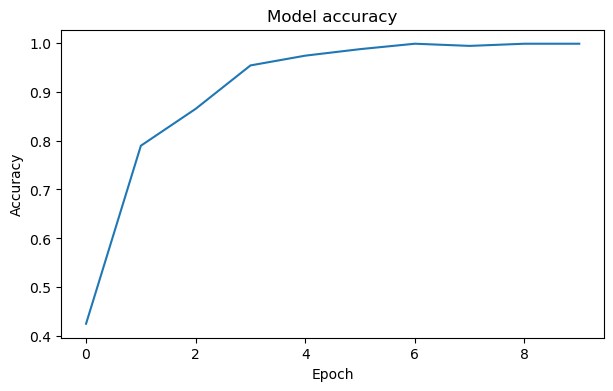

In [19]:
plt.figure(figsize=(7, 4))
plt.plot(history)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

Now, we use the test data to perform an accuracy measurement. Is the accuracy with the testing data much lower than the end of training? If so our model might be overfit.  

We use the Gluon data loader again, this time with the test data.

In [21]:
# TODO: Build our `test_loader` using Gluon's Data Loader with the `test_data`

test_loader = mx.gluon.data.DataLoader(test_data, shuffle=False, batch_size=batch_size)

And measure the accuracy.

In [22]:
metric = mx.metric.Accuracy()
for inputs, labels in test_loader:
    inputs = inputs.as_in_context(ctx)
    labels = labels.as_in_context(ctx)
    metric.update(labels, net(inputs))
metric_name, metric_value = metric.get()
print(f'Validation: {metric_name} = {metric_value}')

Validation: accuracy = 0.9666666666666667


# 5) Test the Model

In order to make our tests look good, we define a couple of functions to dispaly the results.

In [23]:
# Function to display the image:
def plot_image(predictions_array, true_label, img):
    plt.xticks([])
    plt.yticks([])
    #Image data is currently a flat array. Convert to matrix for display
    plt.imshow(img.reshape((48,48)).asnumpy(), cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions_array)
    probability = 100 * np.max(predictions_array)
    color = 'green' if predicted_label == true_label else 'red'
    # Print a label with 'predicted class' 'actual class'
    plt.xlabel(f"{class_names[predicted_label]} ({true_label} - {class_names[true_label]})",
                                color=color)

# Function to display the prediction results in a graph:
def plot_value_array(predictions_array, true_label):
    plt.xticks(range(10))
    plt.yticks([])
    plot = plt.bar(range(10), predictions_array, color="#777777")
    predicted_label = np.argmax(predictions_array)
    plot[predicted_label].set_color('red')
    plot[true_label].set_color('green')

## Single Prediction

Let's test out model. Choose one of the images from our test set.

In [24]:
prediction_image_number = 25
prediction_image, prediction_label = test_data[prediction_image_number]

Now make a prediction.

In [25]:
# TODO: Run the `prediction_image` through the model

predictions_single = net(prediction_image)
predictions_single


[[-0.9705147 -0.7037516  7.2353315 -5.1454134 -7.352009   2.6982245
  -1.276078   2.3788803 -2.0079963 -4.651187 ]]
<NDArray 1x10 @cpu(0)>

Let's plot a bar chart using the helper function. This gives us a sense of how well the model classified this image. The predicted label will be red if it is different than the actual label. The actual label will be green.

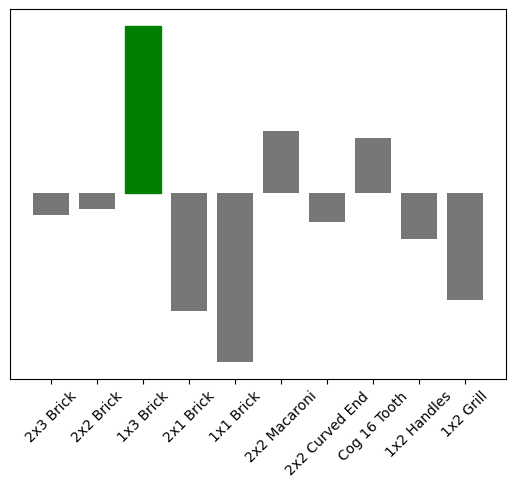

In [26]:
plot_value_array(predictions_single[0].asnumpy(), prediction_label)
plt.xticks(range(10), class_names, rotation=45)
plt.show()

And which block should we have found? In other words, did we get it right?

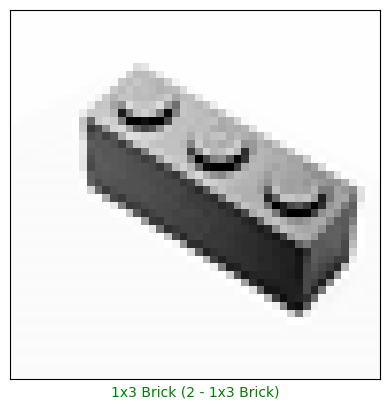

In [27]:
plot_image(predictions_single[0].asnumpy(), prediction_label, prediction_image)

## Batch Prediction

Now lets get prediction values for **all** the test images we have. This time we don't use a data loader, we just iterate through the raw test image data.

In [28]:
predictions = []
test_labels = []

for i in test_data:
    pred_image, pred_label = i
    p = net(pred_image)
    predictions.append(p)
    test_labels.append(pred_label)    

Finally, let's use our helper functions to summarize the first 16 images in our test data. How did we do?

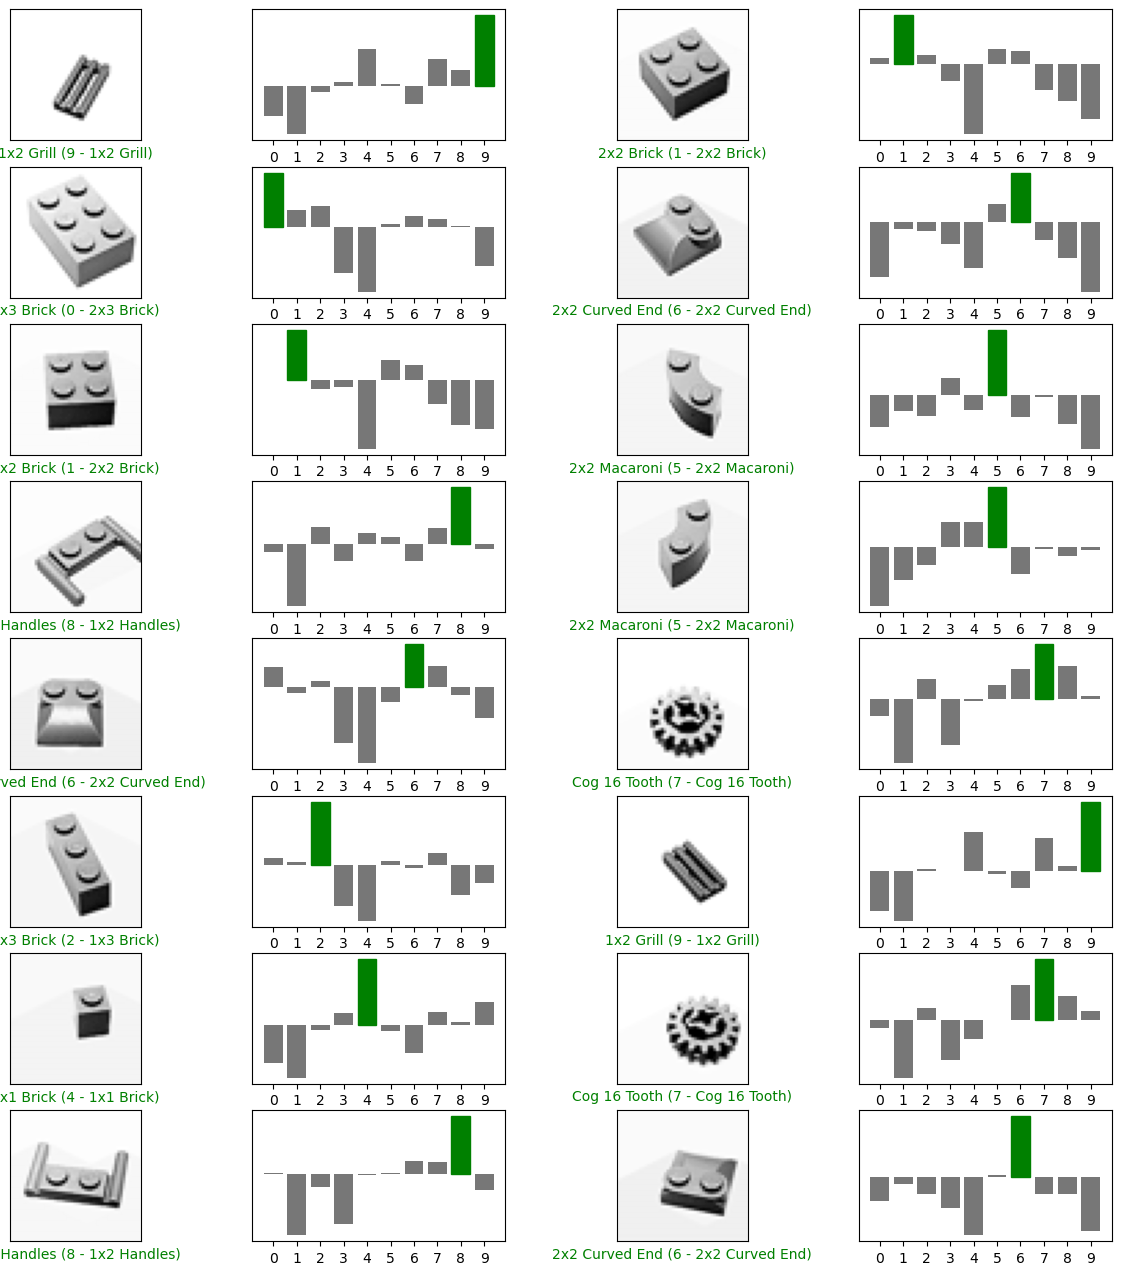

In [29]:
num_rows = 8
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(15, 16))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(predictions[i].asnumpy(), test_data[i][1], test_data[i][0])
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(predictions[i][0].asnumpy(), test_data[i][1])
plt.show()

## Conclusion
I got an accuracy of about 95%. Your model might be slightly higher or lower. For your actual problem (sorting the blocks), is approximately 95% accuracy good enough for you? Are you willing to have about 1 in 20 of your bricks in the wrong place for the advantage of not having to manually decide which type of brick you are sorting? That's up to you! You can also analyze which bricks the model is consistently getting wrong and reorganize those bins yourself once the model is finished. Machine learning is just one tool and one option.

Use the rest of your lab time to experiment with the model architecture to see if you can improve on your current accuracy. Try using another random seed. You can also change the number of training epochs, but be careful not to overfit your model!